<a href="https://colab.research.google.com/github/SaKi1309/MasterthesisVolograms/blob/master/VologramsData_Playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TO CHECK:

Send E-Mail when Ready....

Check output on Phone! https://github.com/hyperdashio/hyperdash-sdk-py/blob/master/README.md

https://medium.com/@ankushchoubey/my-top-10-un-popular-google-collab-tips-53e7b57e3248

<a name="0"></a>
# 0. Initial steps

<a name="0-1"></a>
## 0.1 Mounting the Google Drive

Please run the next code cell and follow these steps to mount your Google Drive so that it can be accessed by this Colab.

Opt 1.
- Uncomment and run the code cell below.  A web link will appear below the cell. HAs to be done with every run time

Opt 2.
- Permanently mount drive in the file system

In [1]:
#from google.colab import drive
#drive.mount('/content/drive/', force_remount=True)

<a name="0-2"></a>
## 0.2 Prepare Real Time Datalogging on Phone

In order to review the output of destinct cells at any time, HyperDash is used.

Link: https://hyperdash.io/ 

In order to track a cell, it needs to be marked with: 

%%monitor_cell “MasterThesis/PatchGAN” 

In [2]:
#!pip install hyperdash && hyperdash login --github

In [3]:
#from hyperdash import monitor_cell

<a name="1"></a>
# 1. Environment

<a name="1-1"></a>
## 1.1 Importing Libraries

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
#import tensorflow_datasets as tfds
import os
import cv2
from tqdm import tqdm
import tensorflow_addons as tfa
import random
import time

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.4.0


<a name="1-2"></a>
## 1.2 Distribution Strategy - HW Detection
Depending on the hardware available, different distribution strategies will be applied.

- If the TPU is available, the TPU Strategy is used.
Otherwise:
- If more than one GPU is available, then the Mirrored Strategy is applied
- If one GPU is available or if just the CPU is available, the default strategy is applied.

OVerview Distribution: https://www.tensorflow.org/api_docs/python/tf/distribute

Tutorial of using td.distrubute on custom training: https://www.tensorflow.org/tutorials/distribute/custom_training

In [5]:
# Detect hardware
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
  tpu = None
  gpus = tf.config.experimental.list_logical_devices("GPU")
    
# Select appropriate distribution strategy
if tpu:
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.TPUStrategy(tpu) # Going back and forth between TPU and host is expensive. Better to run 128 batches on the TPU before reporting back.
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])  
elif len(gpus) > 1:
  strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
  print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on single GPU ', gpus[0].name)
else:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on CPU')
print("Number of accelerators: ", strategy.num_replicas_in_sync)

INFO:tensorflow:Initializing the TPU system: grpc://10.45.85.18:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.45.85.18:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Running on TPU  ['10.45.85.18:8470']
Number of accelerators:  8


<a name="1-3"></a>
## 1.3 Global Parameters

In [6]:
DATA_PATH_SYNTHETIC = os.path.join("/content","drive","My Drive","Master","DatasetVolograms", "Synthetic_Data_Samples")
DATA_PATH_TARGET = os.path.join("/content","drive","My Drive","Master","DatasetVolograms", "Target_Data_Samples")

# The global batch size is the batch size per replica (1 in this case) times the number of replicas in the distribution strategy (In Colab: 8 for TPU, 1 for GPU and CPU).
BATCH_SIZE = 1
GLOBAL_BATCH_SIZE = BATCH_SIZE * strategy.num_replicas_in_sync

# Used for the data piple to feed the data to the network
BUFFER_SIZE = 256

# RGBD Image: Height = Width = 512, Channel: Red, Green, Blue, Depth
IMG_SIZE = (512,512,4)

# Weights initializer for the layers.
KERNEL_INIT = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

# Gamma initializer for instance normalization.
GAMMA_INIT = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

#autotune function for parallelism.
AUTOTUNE = tf.data.experimental.AUTOTUNE

#Directory for checkpoints
#checkpoint_dir = './training_checkpoints'
#checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

<a name="2"></a>
# 2. Utilities and Helper Functions

In [7]:
#Remove _RGB_ and _DEPTH_ from the file names to ensure same naming...
def Prepare_filename(directory):
  for filename in os.listdir(directory):
    #os.rename(os.path.join(directory, filename), os.path.join(directory, newFilename))
    if "_RGB_" in filename:
      newFilename = filename.replace("_RGB_","_")
      os.rename(os.path.join(directory, filename), os.path.join(directory, newFilename))
    elif "_DEPTH_" in filename:
      newFilename = filename.replace("_DEPTH_","_")
      os.rename(os.path.join(directory, filename), os.path.join(directory, newFilename))

In [8]:
#loads RGB and DEPTH images and combines them into one RGBD Dataset. Shape (sample, Height, Width, Channel). Channel: R,G,B,D
def Combine_color_depth(directory):
    
  #get list from all filenames without file extension. Note that RGB and EXR need to have the same name!
  fileNames = [".".join(f.split(".")[:-1]) for f in os.listdir(directory)]
  
  #Hack to remove duplicates from List
  fileNames = list(dict.fromkeys(fileNames))

  #randomize Filenames!
  random.shuffle(fileNames)
  
  numberOfFiles = len(fileNames)

  #empty array container
  combined = np.zeros(shape = (numberOfFiles, 512, 512, 4), dtype=float)

  #setup progressbar
  pbar = tqdm(total=numberOfFiles, position=0, leave=True, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} ')
  

  for i in range(0, numberOfFiles):
    currentFile = os.path.join(directory,fileNames[i])
    image = cv2.imread(currentFile + '.png')[:,:,::-1] #OPEN CV reads images in BGR not in RGB!!!!
    depth = cv2.imread(currentFile + '.exr', cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)

    #print("Iteration {} of {}: Image = {},  Depth = {}".format(i, numberOfFiles, image.shape, depth.shape))
    
    image = image/255;
    depth = depth/5;
    
    combined[i,:,:,0:3] = image
    combined[i,:,:,3] = depth

    pbar.set_description("Load images") #works better if set in every loop! 
    pbar.update()

  #print("Combined = {}".format(combined.shape))
  
  return combined

In [9]:
def Create_tensorflow_dataset(data, trainSplit = None):
  '''
  Creates a dataset from a numpy tensor.

  Params:  
    1. data: Numpy array
    2. trainSplit: float between 0...1 or None. If None, complete data will be returned as dataset. If float, a training and a testset will be returned according the ratio
  '''

  numberOfSamples = data.shape[0]
  
  if trainSplit == None:
    dataset = tf.data.Dataset.from_tensor_slices(data)
    print("\nDataset created. Total samples: {}, training split: None".format(numberOfSamples))
    return dataset
  else:
    assert trainSplit <= 1.0 and trainSplit >=0 , "trainSplit needs to be a float between 0...1"
    train_size = int(trainSplit * numberOfSamples)
    train = tf.data.Dataset.from_tensor_slices(data[:train_size,...])
    test = tf.data.Dataset.from_tensor_slices(data[train_size:,...])
    

    print("\nDataset created. Total samples: {}, training split: {}, training samples: {}, test samples: {}".format(numberOfSamples, trainSplit, train_size, numberOfSamples-train_size))
    return [train, test]
  
  
  
  #print(dataset)
  #dataset = dataset.take(3)
  #print(list(dataset.as_numpy_iterator()))


  #path = os.path.join("Datasets","dataset")
  #tf.data.experimental.save(dataset, path)
  # new_dataset = tf.data.experimental.load(path, tf.TensorSpec(shape=(30,512,512,4), dtype=tf.float32))

  #new_dataset = dataset.take(3)
  #print(list(new_dataset.as_numpy_iterator()))
  #print(new_dataset)
    

In [10]:
def Plot_RGBD_Sample(rgbd, title = "RGBD Plot"):
  fig = plt.figure()
  fig = plt.figure(figsize=[12,6])
  fig.suptitle(title, fontsize=20)
  ax = fig.add_subplot(1, 2, 1)
  imgplot = plt.imshow(rgbd[:,:,0:3])
  ax.set_title('RGB')
  #plt.colorbar(ticks=[0.1, 0.3, 0.5, 0.7], orientation='horizontal')
  ax = fig.add_subplot(1, 2, 2)
  imgplot = plt.imshow(rgbd[:,:,3])
  #imgplot.set_clim(0.0, 0.7)
  ax.set_title('Depth')
  #plt.colorbar(ticks=[0.1, 0.3, 0.5, 0.7])
  plt.show()

def Plot_Multiple_RGBD(rgbd_samples, count = 6):
  fig = plt.figure(figsize=[20,20])
  samplesToPlot = min(rgbd_samples.shape[0], count)
  for i in range(0, samplesToPlot):
    ax = fig.add_subplot(3, 4, i*2+1)
    imgplot = plt.imshow(rgbd_samples[i,:,:,0:3])
    ax.set_title('RGB')
    #plt.colorbar(ticks=[0.1, 0.3, 0.5, 0.7], orientation='horizontal')
    ax = fig.add_subplot(3, 4, i*2+2)
    imgplot = plt.imshow(rgbd_samples[i,:,:,3])
    #imgplot.set_clim(0.0, 0.7)
    ax.set_title('Depth')
    #plt.colorbar(ticks=[0.1, 0.3, 0.5, 0.7])
  plt.show()

<a name="3"></a>
# 3. Preparing the Data

TODO: kapitel passen nicht mehr nachdem etwas bearbeitet...

<a name="3-1"></a>
## 3.1 Load and Analyze Data

When run the first time, data is downloaded from the drive and stored in the colab session. after that it runs faster.

In [11]:
#Load data
rgbd_synthetic = Combine_color_depth(DATA_PATH_SYNTHETIC)
rgbd_target = Combine_color_depth(DATA_PATH_TARGET)


Load images: 100%|██████████| 30/30 

<Figure size 432x288 with 0 Axes>

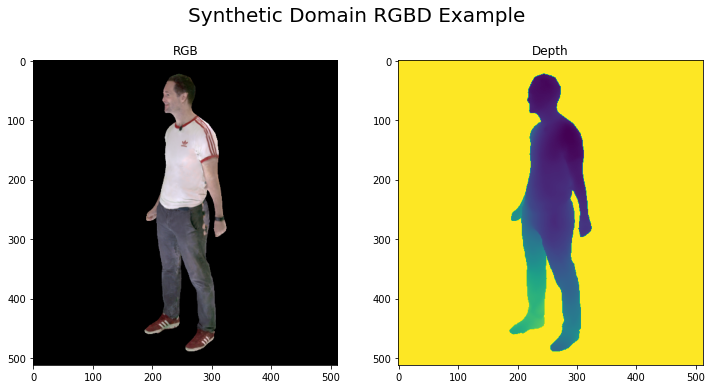

<Figure size 432x288 with 0 Axes>

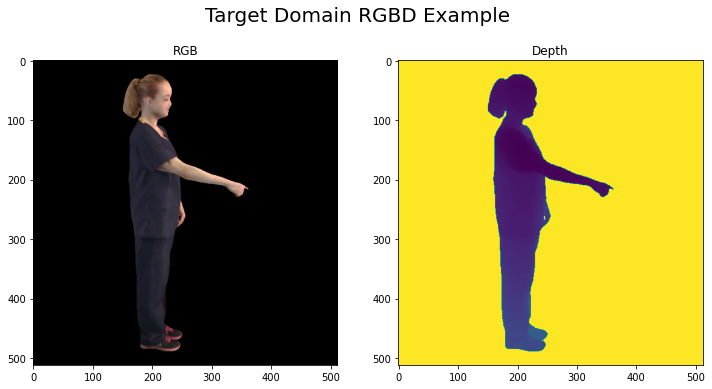

In [12]:
#Inspect Datasamples
Plot_RGBD_Sample(rgbd_synthetic[0,...], "Synthetic Domain RGBD Example")
Plot_RGBD_Sample(rgbd_target[0,...], "Target Domain RGBD Example")

<a name="3-x"></a>
## 3.x Principal COmponent Analysis

(1797, 64)
(1797, 2)


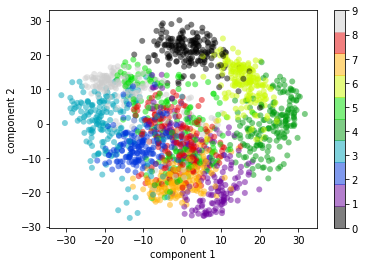

In [13]:
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
digits = load_digits()
digits.data.shape

pca = PCA(2)  # project from 64 to 2 dimensions
projected = pca.fit_transform(digits.data)
print(digits.data.shape)
print(projected.shape)

plt.scatter(projected[:, 0], projected[:, 1],
            c=digits.target, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

In [14]:
pca = PCA(4)
print("rgbd_synthetic.shape: {}".format(rgbd_synthetic.shape))
temp = np.reshape(rgbd_synthetic,(30,1048576))
temp1 = temp[:15]
temp2 = temp[15:]
print("temp1.shape: {}".format(temp1.shape))
print("temp2.shape: {}".format(temp2.shape))
projected1 = pca.fit_transform(temp1)
projected2 = pca.fit_transform(temp2)
print("projected1.shape: {}".format(projected1.shape))
print("projected2.shape: {}".format(projected2.shape))

rgbd_synthetic.shape: (30, 512, 512, 4)
temp1.shape: (15, 1048576)
temp2.shape: (15, 1048576)
projected1.shape: (15, 10)
projected2.shape: (15, 10)


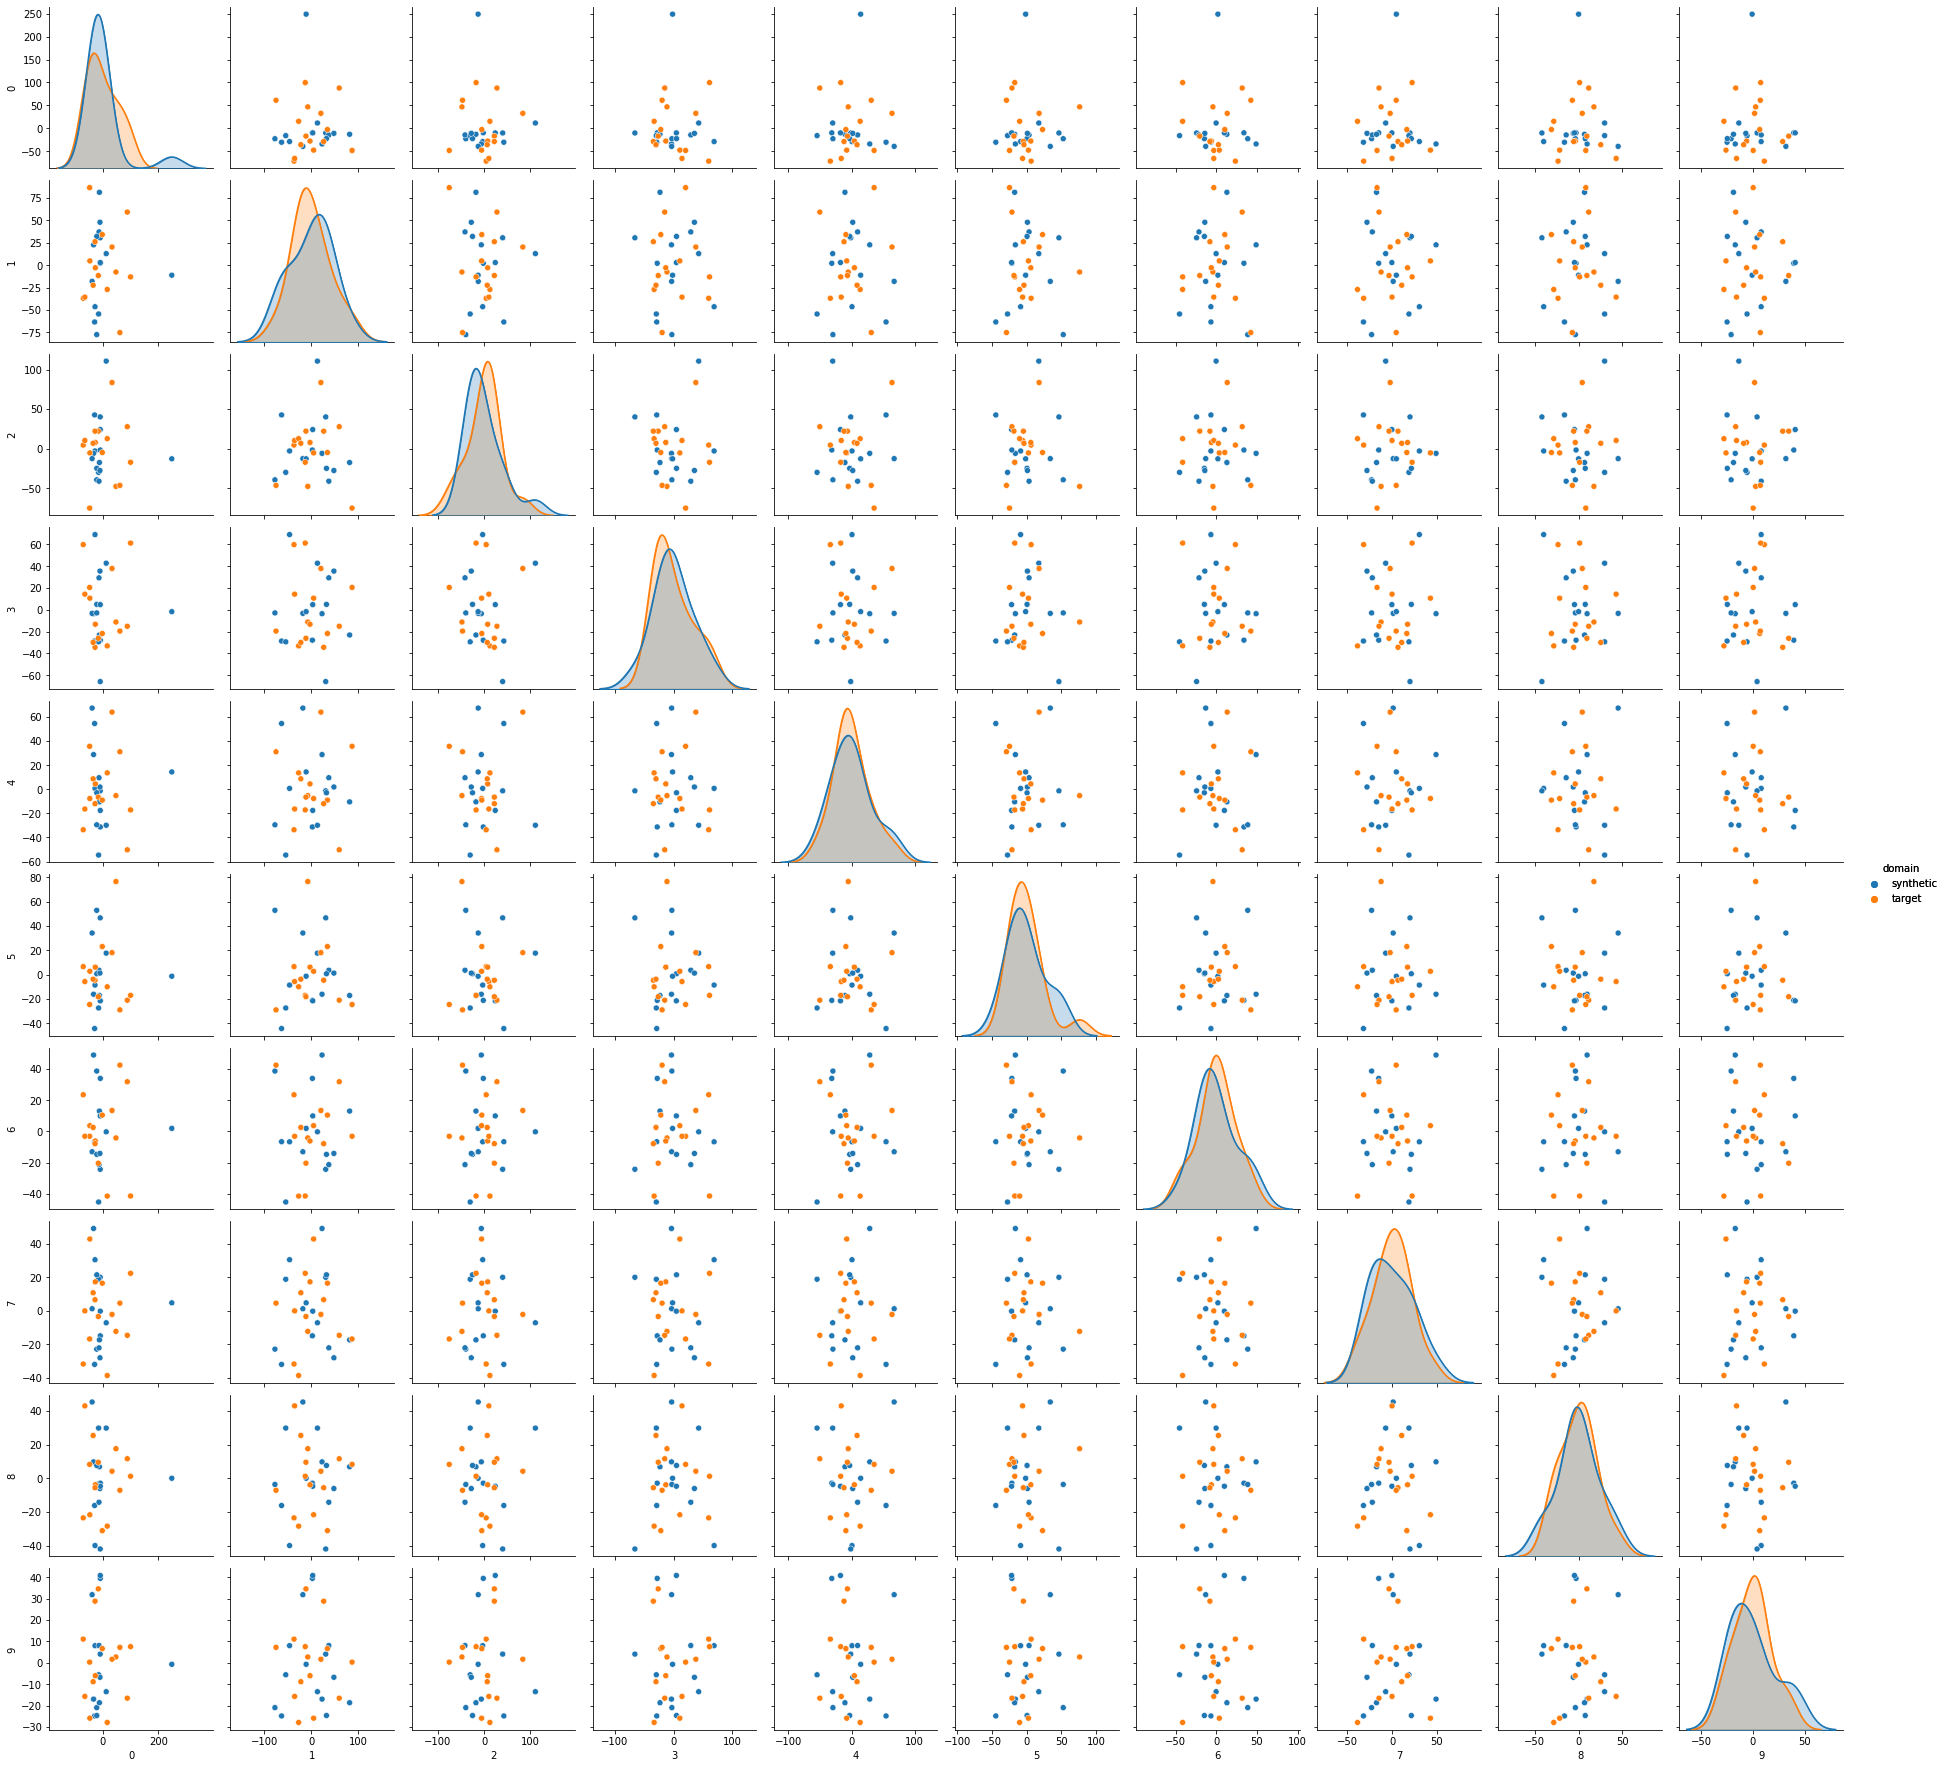

In [15]:
import seaborn as sns
import pandas as pd

df1 = pd.DataFrame(projected1)
df1['domain'] = 'synthetic'
df2 = pd.DataFrame(projected2)
df2['domain'] = 'target'
df12 = df1.append(df2)


g = sns.pairplot(data=df12, hue='domain')
g.map_diag(sns.kdeplot)
g.add_legend()

rgbd_synthetic.shape: (30, 512, 512, 4)
temp.shape: (30, 1048576)
projected.shape: (30, 10)


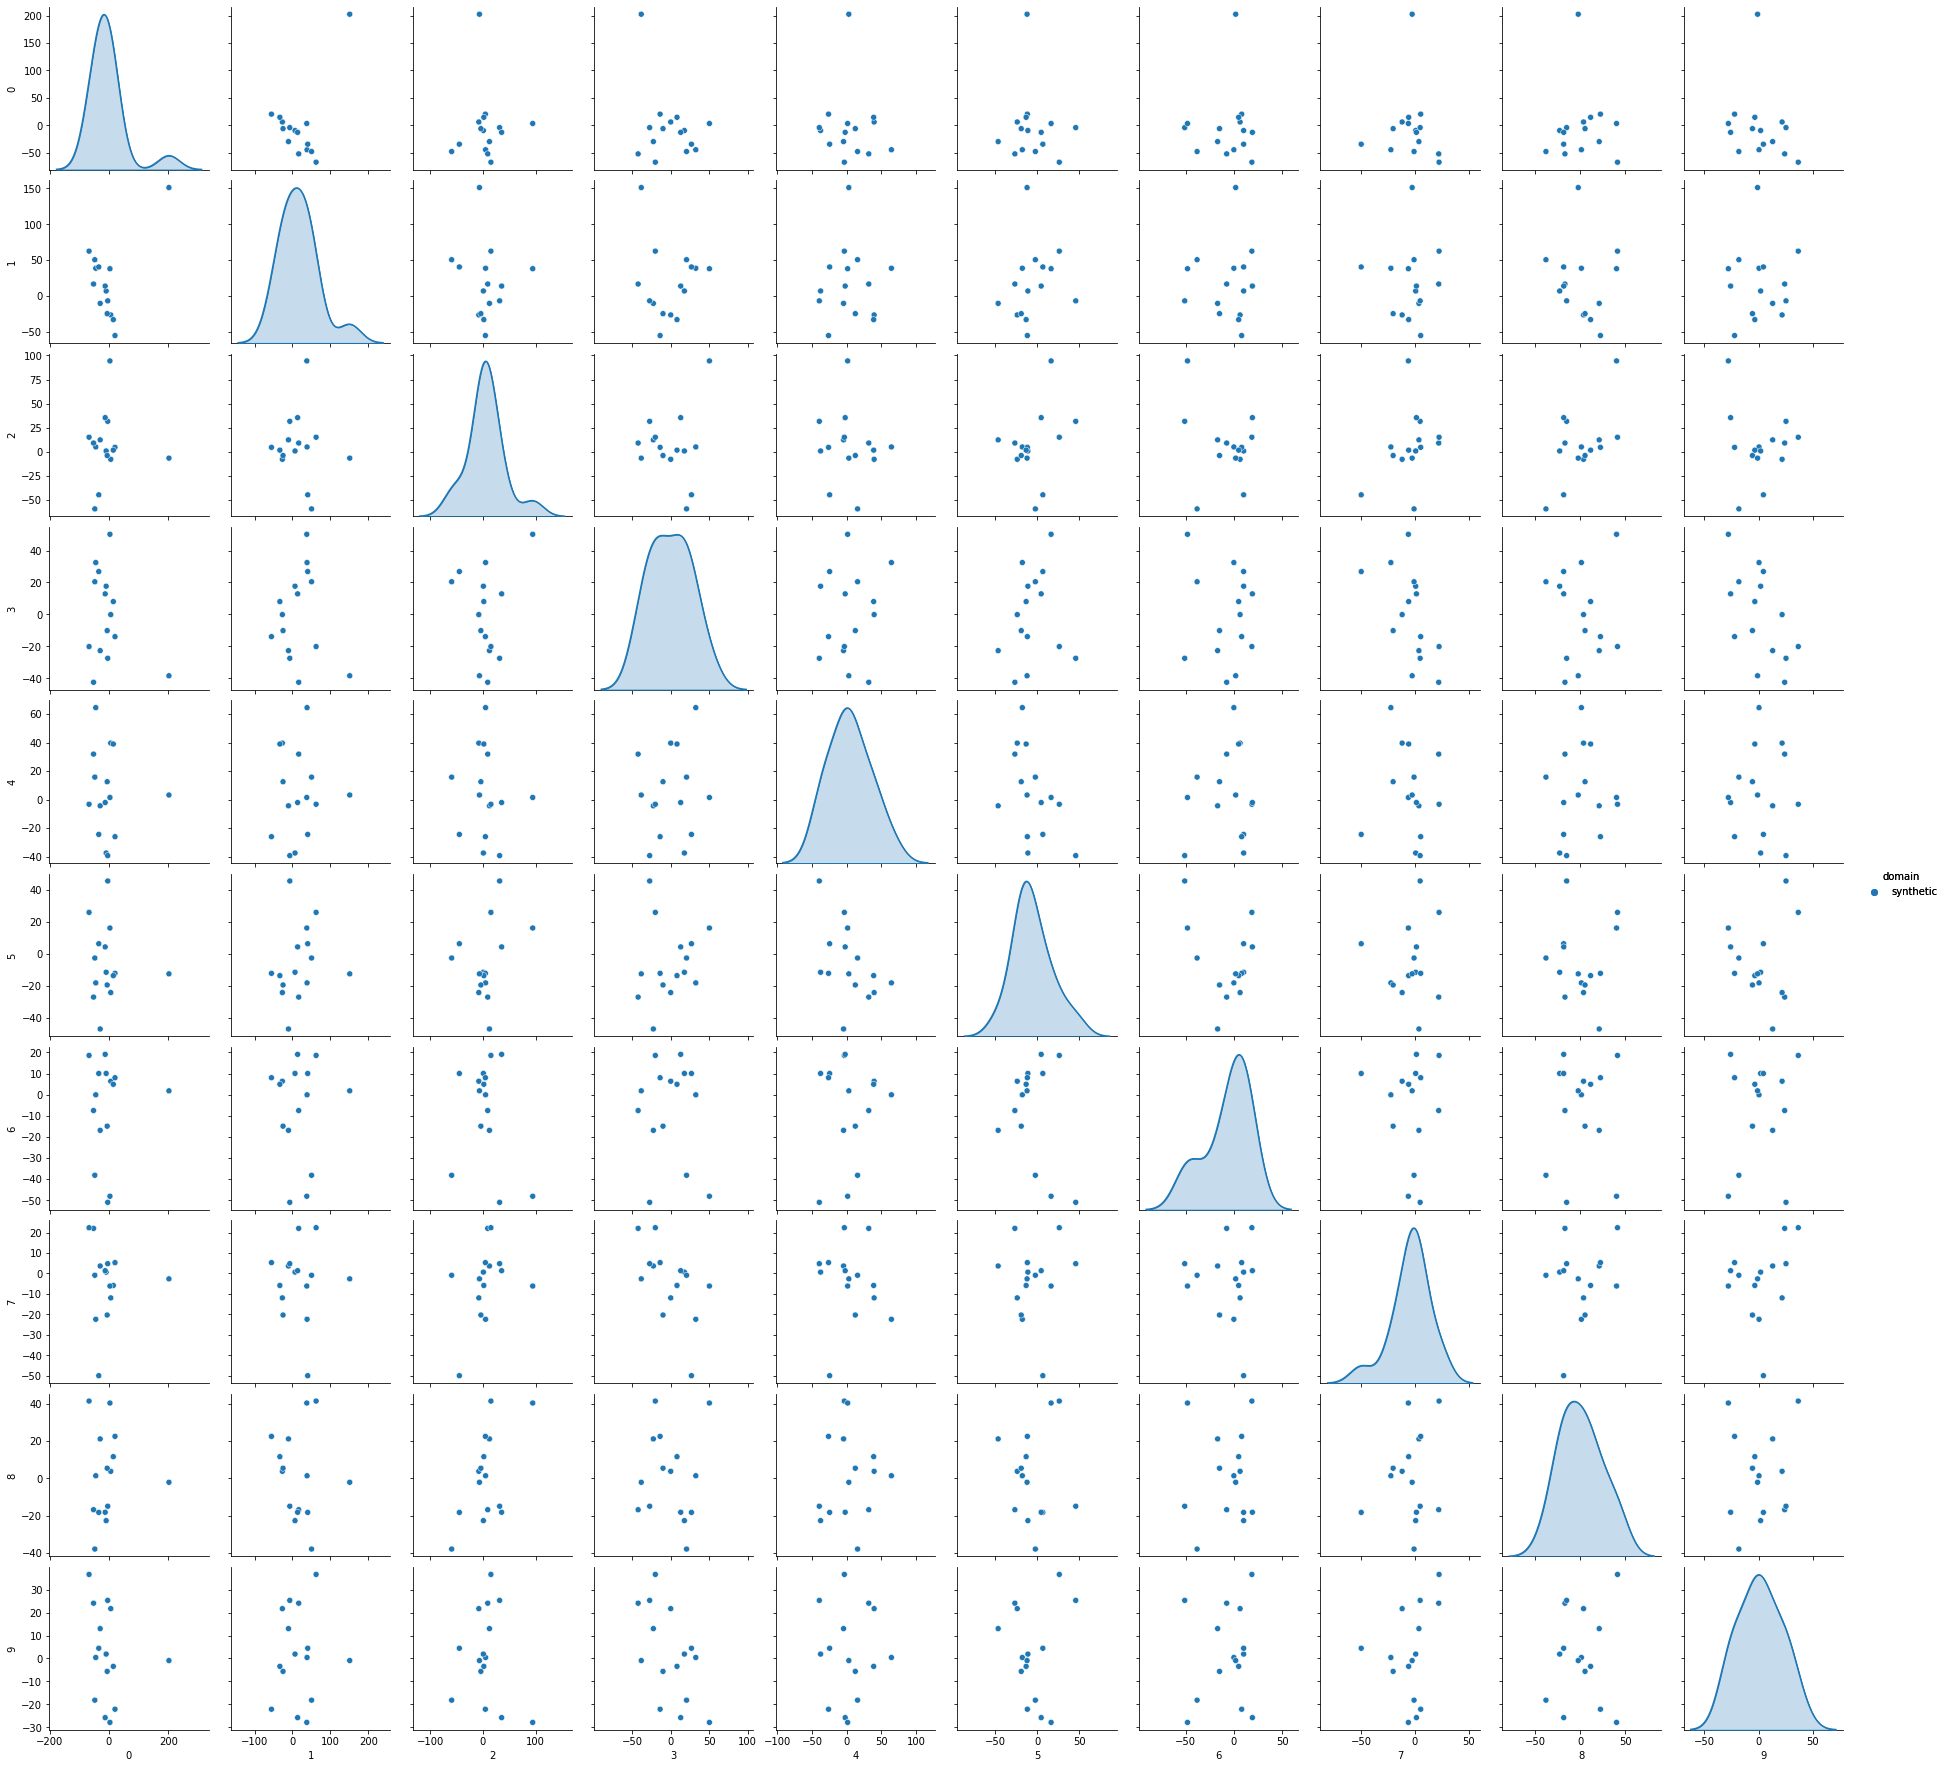

In [16]:
pca = PCA(4)
print("rgbd_synthetic.shape: {}".format(rgbd_synthetic.shape))
temp = np.reshape(rgbd_synthetic,(30,1048576))

print("temp.shape: {}".format(temp.shape))

projected = pca.fit_transform(temp)
print("projected.shape: {}".format(projected.shape))


import seaborn as sns
import pandas as pd

df1 = pd.DataFrame(projected[:15])
df1['domain'] = 'synthetic'
df2 = pd.DataFrame(projected2[15:])
df2['domain'] = 'target'
df12 = df1.append(df2)


g = sns.pairplot(data=df12, hue='domain')
g.map_diag(sns.kdeplot)
g.add_legend()

<a name="3-2"></a>
## 3.2 Define Preprocessing

To check:


1.   Werden bei dataaugmentation wirklich neue samples erzeugt, oder werden einfach nur die batches jedes mal neu geshuffelt zund somit ist in jeder epoche die Daten anders?

2.   Checken wie ich die depth daten am besten normalisiere... in den synthetischen ist der max value 5, der background. Die daten von der target domain kenne ich noch nicht... 


Tensorflow Image API: https://www.tensorflow.org/api_docs/python/tf/image

Guide for Data Augmentation here: https://www.tensorflow.org/tutorials/images/data_augmentation

API for using Keras Layers for augmentation!: https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing



---

Ggf. muss ich das image splitten in RGB und D bevor ich es preprozesse, da viele sachen nur für RGB...



In [17]:
def Normalize_Image(synthetic_rgbd, target_rgbd):
  # TODO: Implement!
  #img = tf.cast(img, dtype=tf.float32)
  #img[:,:,:3] /= 255  #first 3 Channel are RGB values, with 8bit, therfore normalize to 0...1
  #img[:,:,3:] /= 5
  return synthetic_rgbd, target_rgbd

In [18]:
def Augmentate_Data(synthetic_rgbd, target_rgbd):
  # Random flip
  synthetic_rgbd = tf.image.random_flip_left_right(synthetic_rgbd)
  target_rgbd = tf.image.random_flip_left_right(target_rgbd)

  return synthetic_rgbd, target_rgbd

In [19]:
#@tf.function
def Preprocess_Train_Data(synthetic_rgbd, target_rgbd):
  synthetic_rgbd, target_rgbd = Augmentate_Data(synthetic_rgbd, target_rgbd)
  synthetic_rgbd, target_rgbd = Normalize_Image(synthetic_rgbd, target_rgbd)
  return synthetic_rgbd, target_rgbd

In [20]:
#@tf.function
def Preprocess_Test_Data(synthetic_rgbd, target_rgbd):
  synthetic_rgbd, target_rgbd = Normalize_Image(synthetic_rgbd, target_rgbd)
  return synthetic_rgbd, target_rgbd

<a name="3-3"></a>
## 3.3 Define Dataset Pipeline

Information to applied functions here: https://www.tensorflow.org/api_docs/python/tf/data/Dataset

IMPORTANT: Call Can only be run once in Colab.... after that, the dataset needs to be created newly. 



In [21]:
#TODO: Check interleaving and chaching tequniques
#TODO: Check if the global_batch_size or the batch_size needs to be passed!

def get_Datasets(rgbd_synthetic, rgbd_target):

  ''' 
    Input:
      rgbd_synthetic:   dataset of rgbd images from the synthetic domain. Shape: (num_samples, height, width, channel)
      rgbd_target:      dataset of rgbd images from the target domain. Shape: (num_samples, height, width, channel)
    
    Output:
      train_distributed: Distributed and ziped dataset of training images ((batch, height, width, channel),(batch, height, width, channel)) where ((train_synthetic),(train_target))
      test_distributed: Distributed and ziped dataset of test images ((batch, height, width, channel),(batch, height, width, channel)) where ((test_synthetic),(test_target))
  '''
  print("Get Datasets ...")
  #Create Tensorflow Datasets for the synthetic and the target data and split them into training and test sets. 
  train_synthetic, test_synthetic = Create_tensorflow_dataset(rgbd_synthetic, trainSplit = 0.8)
  train_target, test_target = Create_tensorflow_dataset(rgbd_target, trainSplit = 0.8)

  #create a single train set and a single test set from the synthetic and the target data. IMPORTANT: Shapes need to match
  train = tf.data.Dataset.zip((train_synthetic, train_target))
  test = tf.data.Dataset.zip((test_synthetic, test_target))

  #print(train)
  #print(train.__len__())
  #print(test)
  #print(test.__len__())
  
  #define dataset input pipelines!
  train = (
    train.map(Preprocess_Train_Data, num_parallel_calls=AUTOTUNE)
    .shuffle(BUFFER_SIZE)
    .batch(GLOBAL_BATCH_SIZE, drop_remainder=False)
    .prefetch(AUTOTUNE)
  )

  test = (
    test.map(Preprocess_Test_Data, num_parallel_calls=AUTOTUNE)
    .shuffle(BUFFER_SIZE)
    .batch(GLOBAL_BATCH_SIZE, drop_remainder=False)
    .prefetch(AUTOTUNE)
  )

  #create distributed datasets to distribute among TPUs
  train_distributed = strategy.experimental_distribute_dataset(train)
  test_distributed = strategy.experimental_distribute_dataset(test)

  return train_distributed, test_distributed

<a name="4"></a>
# 4. Defining the Model

Usefull Links:


*   Layer API: https://www.tensorflow.org/api_docs/python/tf/keras/layers
*   Model API: https://www.tensorflow.org/api_docs/python/tf/keras/Model
*   Tensorflow AdOns API: https://www.tensorflow.org/addons/api_docs/python/tfa 
*   Tensor Flow Dataset API (not tfds!): https://www.tensorflow.org/api_docs/python/tf/data/Dataset


---




Hint from TensorFlow Documentation (https://www.tensorflow.org/guide/keras/custom_layers_and_models):

"*In general, you will use the Layer class to define inner computation blocks, and will use the Model class to define the outer model -- the object you will train.*"

Ich werde trotzdem ein Model nehmen, einfach wegen summary and plot!







<a name="4-1"></a>
## 4.1 Custom Layer
Keep in Mind: There are <b>no activations possible in custom layers</b> if not manually implemented!

<a name="4-2"></a>
## 4.2 Sub-Model Blocks

<a name="4-2-1"></a>
### 4.2.1 Down-Sample Model Block

<b>TODO:</b> 


1.   Vergleich verschiedener Downsample Blöcke.
  1.   Conv2D
  2.   Pooling
  3.   Downsample Block
  3.   Mehrere Convolution, dann downsampling






In [22]:
def DownSampleBlock(input, numOfChannels, channelExpansionFactor = 2, kernel_size = (3,3), kernel_initializer = KERNEL_INIT, gamma_initializer = GAMMA_INIT, activation = 'relu'):
  filters = channelExpansionFactor * numOfChannels

  x = tf.keras.layers.Conv2D(filters, kernel_size, strides=(2,2), kernel_initializer = kernel_initializer, padding='same', use_bias = False)(input)
  x = tfa.layers.InstanceNormalization(gamma_initializer = gamma_initializer)(x)
  x = tf.keras.activations.get(activation)(x)
  return x

<a name="4-2-2"></a>
### 4.2.2 Up-Sample Model Block

In [23]:
def UpSampleBlock(input, numOfChannels, channelReductionFactor = 2, name = None, kernel_size = (3,3), kernel_initializer = KERNEL_INIT, gamma_initializer = GAMMA_INIT, activation = 'relu'):
  filters = int(numOfChannels / channelReductionFactor)
  x = tf.keras.layers.Conv2DTranspose(filters,kernel_size,strides=(2,2),kernel_initializer = kernel_initializer,padding='same',use_bias = False)(input)
  x = tfa.layers.InstanceNormalization(gamma_initializer = gamma_initializer)(x)
  x = tf.keras.activations.get(activation)(x)
  return x

<a name="4-2-4"></a>
### 4.2.4 Residual Identity Model Block

Der unten gezeigte Residualblock unterscheidet sich noch von dem CycleGAN Beispiel...

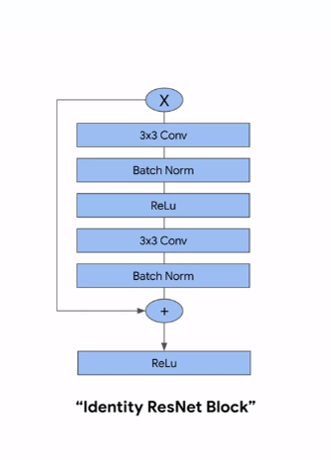

In [24]:
def ResidualIdentityBlock(input, filters = 4, kernel_size = (3,3), strides = (1,1), activation = 'relu'):

  x = tf.keras.layers.Conv2D(filters, kernel_size, strides, padding = 'same')(input)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.activations.get(activation)(x)

  x = tf.keras.layers.Conv2D(filters, kernel_size, strides, padding = 'same')(x)
  x = tf.keras.layers.BatchNormalization()(x)

  x = tf.keras.layers.Add()([x, input])
  x = tf.keras.activations.get(activation)(x)

  return x 

<a name="4-3"></a>
## 4.3 Loss Functions

loss Reduction Explanation: https://www.tensorflow.org/api_docs/python/tf/keras/losses/Reduction

In [25]:
reductionStrategy = tf.keras.losses.Reduction.NONE

# Loss function for evaluating adversarial loss
adv_loss_fn = tf.keras.losses.MeanSquaredError(reduction=reductionStrategy)
#adv_loss_fn = tf.keras.losses.BinaryCrossentropy(reduction=reductionStrategy,from_logits=True)

# Define the loss function for the generators
def generator_loss_fn(generated):
  gen_loss = adv_loss_fn(tf.ones_like(generated), generated)
  #manually reduce with reduce_sum and average with GLOBAL_BATCH_SIZE
  shape = tf.size(gen_loss, tf.float32)
  gen_loss = tf.reduce_sum(gen_loss) * (1. / GLOBAL_BATCH_SIZE) * (1. / shape)
  
  return gen_loss

# Define the loss function for the discriminators
def discriminator_loss_fn(real, generated):
  real_loss = adv_loss_fn(tf.ones_like(real), real)
  generated_loss = adv_loss_fn(tf.zeros_like(generated), generated)
  disc_loss = (real_loss + generated_loss) * 0.5
  shape = tf.size(disc_loss, tf.float32)
  disc_loss = tf.reduce_sum(disc_loss) * (1. / GLOBAL_BATCH_SIZE) * (1. / shape)

  return disc_loss

def cycle_loss_fn(real, cycled):

  real = tf.cast(real, tf.dtypes.float32)
  cycled = tf.cast(cycled, tf.dtypes.float32)

  abs_diff = tf.abs(real - cycled)
  shape = tf.size(abs_diff, tf.float32)

  cycle_loss = tf.reduce_mean(abs_diff) * (1. / GLOBAL_BATCH_SIZE) * (1. / shape)

  return cycle_loss

def identity_loss_fn(real, same):
  real = tf.cast(real, tf.dtypes.float32)
  same = tf.cast(same, tf.dtypes.float32)

  abs_diff = tf.abs(real - same)
  shape = tf.size(abs_diff, tf.float32)

  identity_loss = tf.reduce_mean(tf.abs(real - same)) * (1. / GLOBAL_BATCH_SIZE) * (1. / shape)
 
  return identity_loss


Below is a test to understand the behavior of the different reduction settings:
- tf.keras.losses.Reduction.SUM
- tf.keras.losses.Reduction.NONE
- tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE

When working with distributed strategies on TPUs, only SUM and NONE are allowed, since the batch is splitted among devices.

<b>Problem:</b> 

the loss objective of cycle GAN assumes a dimensional reduction in order to be able to add the different losses together to the total loss: 

- Total loss = adversarial loss + cycle loss + identity loss

Since the different loss terms come from different models (generator or discriminator) they have different shapes which prevents them from beeing added. Therfore, if i specify NONE, there will be an arror in the train_step()-method of the cycleGAN. If I use SUM, I can run this mehtod, but the loss is super high. 

My possible solution:
1. Define the loss functions with tf.keras.losses.Reduction.NONE
2. in the method train_step() in the cycleGAN class, I manually reduce the dimensions by calculating Loss_Batch = sum(loss_NONE) / prod(loss_NONE.shape) as proven in the test bellow. This gives me the sum over the local batch of the current replica with the batch_size = BATCH_SIZE
3. In the distributed_train_step, I reduce the results from the replicas using the reduction technique SUM. The sum is over all local batches of the replicas.
4. In the training loop, ...

In [26]:
#Test Code!
#fake_Image = [[[0,1],[2, 3]],
#              [[0,1],[2, 3]],
#              [[0,1],[2, 3]],
#              [[0,1],[2, 3]],] 

fake_Image = tf.random.normal(shape=(3,2,2,4))
#fake_Image = 2 * tf.ones(shape=(3,2,2,4))


label = tf.ones_like(fake_Image)
#print(fake_Image)
#print(label)

#define different loss functions
loss_fn_SUM = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM)
loss_fn_NONE = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)
loss_fn_BATCH = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE)

#calculate loss
loss_SUM = loss_fn_SUM(label, fake_Image)
loss_NONE = loss_fn_NONE(label, fake_Image)
loss_BATCH = loss_fn_BATCH(label, fake_Image)

print("------------------------------------------------------------------------------")
print("Print Results of calculating loss using loss_fn")
print("------------------------------------------------------------------------------")
print("loss_SUM: {}, shape:{}".format(loss_SUM,loss_SUM.shape))
print("loss_NONE: {}, shape:{}".format(loss_NONE,loss_NONE.shape))
print("loss_BATCH: {}, shape:{}".format(loss_BATCH,loss_BATCH.shape))

#double Check!
print("------------------------------------------------------------------------------")
print("Double Check Results")
print("------------------------------------------------------------------------------")
print("Calculated sum of all elements of loss_None: {} -> sum(loss_NONE) = loss_SUM".format(np.sum(loss_NONE)))
print("Shape of loss_None: {}, product of all elements of the shape:{}".format(loss_NONE.shape, np.prod(loss_NONE.shape)))
print("Loss_Batch = sum(loss_NONE) / prod(loss_NONE.shape) -> {} = {} / {}".format(loss_BATCH,np.sum(loss_NONE), np.prod(loss_NONE.shape)))

#RESULT: loss_batch = sum of all elements in loss_NONE / (shape(none)) = loss_SUMM / Shape(loss_None)

------------------------------------------------------------------------------
Print Results of calculating loss using loss_fn
------------------------------------------------------------------------------
loss_SUM: 14.01768684387207, shape:()
loss_NONE: [[[0.7161256  0.8329978 ]
  [0.81327605 0.24949615]]

 [[1.7104079  3.8103232 ]
  [0.33684388 1.1505051 ]]

 [[2.4721498  0.54831475]
  [0.84807986 0.52916586]]], shape:(3, 2, 2)
loss_BATCH: 1.1681405305862427, shape:()
------------------------------------------------------------------------------
Double Check Results
------------------------------------------------------------------------------
Calculated sum of all elements of loss_None: 14.01768684387207 -> sum(loss_NONE) = loss_SUM
Shape of loss_None: (3, 2, 2), product of all elements of the shape:12
Loss_Batch = sum(loss_NONE) / prod(loss_NONE.shape) -> 1.1681405305862427 = 14.01768684387207 / 12


<a name="4-4"></a>
## 4.4 Model Blocks

<a name="4-4-1"></a>
### 4.4.1 U-Net

Helper:

In [27]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3):
  '''
  Adds 2 convolutional layers with the parameters passed to it

  Args:
    input_tensor (tensor) -- the input tensor
    n_filters (int) -- number of filters
    kernel_size (int) -- kernel size for the convolution

  Returns:
    tensor of output features
  '''
  # first layer
  x = input_tensor
  for i in range(2):
    x = tf.keras.layers.Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
            kernel_initializer = KERNEL_INIT, padding = 'same')(x)
    x = tf.keras.layers.Activation('relu')(x)
  
  return x

Encoder Part:

In [28]:
def encoder_block(inputs, n_filters=64, pool_size=(2,2), dropout=0.3):
  '''
  Adds two convolutional blocks and then perform down sampling on output of convolutions.

  Args:
    input_tensor (tensor) -- the input tensor
    n_filters (int) -- number of filters
    kernel_size (int) -- kernel size for the convolution

  Returns:
    f - the output features of the convolution block 
    p - the maxpooled features with dropout
  '''

  f = conv2d_block(inputs, n_filters=n_filters)
  p = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(f)
  p = tf.keras.layers.Dropout(0.3)(p)

  return f, p


def encoder(inputs):
  '''
  This function defines the encoder or downsampling path.

  Args:
    inputs (tensor) -- batch of input images

  Returns:
    p4 - the output maxpooled features of the last encoder block
    (f1, f2, f3, f4) - the output features of all the encoder blocks
  '''
  f1, p1 = encoder_block(inputs, n_filters=64, pool_size=(2,2), dropout=0.3)
  f2, p2 = encoder_block(p1, n_filters=128, pool_size=(2,2), dropout=0.3)
  f3, p3 = encoder_block(p2, n_filters=256, pool_size=(2,2), dropout=0.3)
  f4, p4 = encoder_block(p3, n_filters=512, pool_size=(2,2), dropout=0.3)

  return p4, (f1, f2, f3, f4)

Bottleneck Part:

In [29]:
def bottleneck(inputs):
  '''
  This function defines the bottleneck convolutions to extract more features before the upsampling layers.
  '''
  
  bottle_neck = conv2d_block(inputs, n_filters=1024)

  return bottle_neck

Decoder Part:

In [30]:
def decoder_block(inputs, conv_output, n_filters=64, kernel_size=3, strides=3, dropout=0.3):
  '''
  defines the one decoder block of the UNet

  Args:
    inputs (tensor) -- batch of input features
    conv_output (tensor) -- features from an encoder block
    n_filters (int) -- number of filters
    kernel_size (int) -- kernel size
    strides (int) -- strides for the deconvolution/upsampling
    padding (string) -- "same" or "valid", tells if shape will be preserved by zero padding

  Returns:
    c (tensor) -- output features of the decoder block
  '''
  u = tf.keras.layers.Conv2DTranspose(n_filters, kernel_size, strides = strides, padding = 'same')(inputs)
  c = tf.keras.layers.concatenate([u, conv_output])
  c = tf.keras.layers.Dropout(dropout)(c)
  c = conv2d_block(c, n_filters, kernel_size=3)

  return c


def decoder(inputs, convs, output_channels):
  '''
  Defines the decoder of the UNet chaining together 4 decoder blocks. 
  
  Args:
    inputs (tensor) -- batch of input features
    convs (tuple) -- features from the encoder blocks
    output_channels (int) -- number of classes in the label map

  Returns:
    outputs (tensor) -- the pixel wise label map of the image
  '''
  
  f1, f2, f3, f4 = convs

  c6 = decoder_block(inputs, f4, n_filters=512, kernel_size=(3,3), strides=(2,2), dropout=0.3)
  c7 = decoder_block(c6, f3, n_filters=256, kernel_size=(3,3), strides=(2,2), dropout=0.3)
  c8 = decoder_block(c7, f2, n_filters=128, kernel_size=(3,3), strides=(2,2), dropout=0.3)
  c9 = decoder_block(c8, f1, n_filters=64, kernel_size=(3,3), strides=(2,2), dropout=0.3)

  outputs = tf.keras.layers.Conv2D(output_channels, (1, 1))(c9)

  return outputs

Final U-Net Model

In [31]:
def UNet(imageShape = (512, 512, 4), name = None):
  '''
  Defines the UNet by connecting the encoder, bottleneck and decoder.
  '''

  # specify the input shape
  inputs = tf.keras.layers.Input(shape = imageShape)

  # feed the inputs to the encoder
  encoder_output, convs = encoder(inputs)

  # feed the encoder output to the bottleneck
  bottle_neck = bottleneck(encoder_output)

  # feed the bottleneck and encoder block outputs to the decoder
  # specify the number of classes via the `output_channels` argument
  outputs = decoder(bottle_neck, convs, output_channels=imageShape[-1])
  
  # create the model
  model = tf.keras.Model(inputs=inputs, outputs=outputs, name = name)

  return model

In [32]:
model = UNet()
model.summary()
#tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=False)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 4) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 64) 2368        input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 512, 512, 64) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 64) 36928       activation[0][0]                 
______________________________________________________________________________________________

In [33]:
#def UNet(inputShape = (512,512,4), name = None, num_up_down_blocks = 4, kernel_initializer = KERNEL_INIT):
  
#  inputImageChannels = inputShape[-1]
#  input_tensor = tf.keras.layers.Input(shape=inputShape)
#  x = input_tensor
  
#  # store skip connections during down sampling, and concatenate during upsampling
#  skips = []

#  #Downsampling Blocks
#  for i in range(num_up_down_blocks):
#      x = DownSampleBlock(input = x, numOfChannels = inputImageChannels * (2**i))
#      skips.append(x)

#  skips = reversed(skips[:-1])

#  for i, skip in zip(reversed(range(num_up_down_blocks)), skips):
#    x = UpSampleBlock(input= x, numOfChannels= inputImageChannels * (2**(i+1)))
#    x = tf.keras.layers.Concatenate()([x, skip])

#  x = tf.keras.layers.Conv2DTranspose(inputImageChannels, 4, strides=2, kernel_initializer = kernel_initializer, padding='same', activation='sigmoid', name = "FinalLayer")(x)

#  return tf.keras.Model(inputs=input_tensor, outputs=x, name = name)


## Test Code
## Test input has the shape of the 1 training example of the dataset
#dataShape = (512, 512, 4)

#uNet = UNet(inputShape = dataShape ,num_up_down_blocks = 4)
#uNet.summary()
#tf.keras.utils.plot_model(uNet, show_shapes=True, expand_nested=True)

<a name="4-4-2"></a>
### 4.4.2 ResNet



Model: "ResNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 512, 512, 4) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 256, 256, 8)  288         input_2[0][0]                    
__________________________________________________________________________________________________
instance_normalization (Instanc (None, 256, 256, 8)  16          conv2d_19[0][0]                  
__________________________________________________________________________________________________
tf.nn.relu (TFOpLambda)         (None, 256, 256, 8)  0           instance_normalization[0][0]     
_____________________________________________________________________________________________

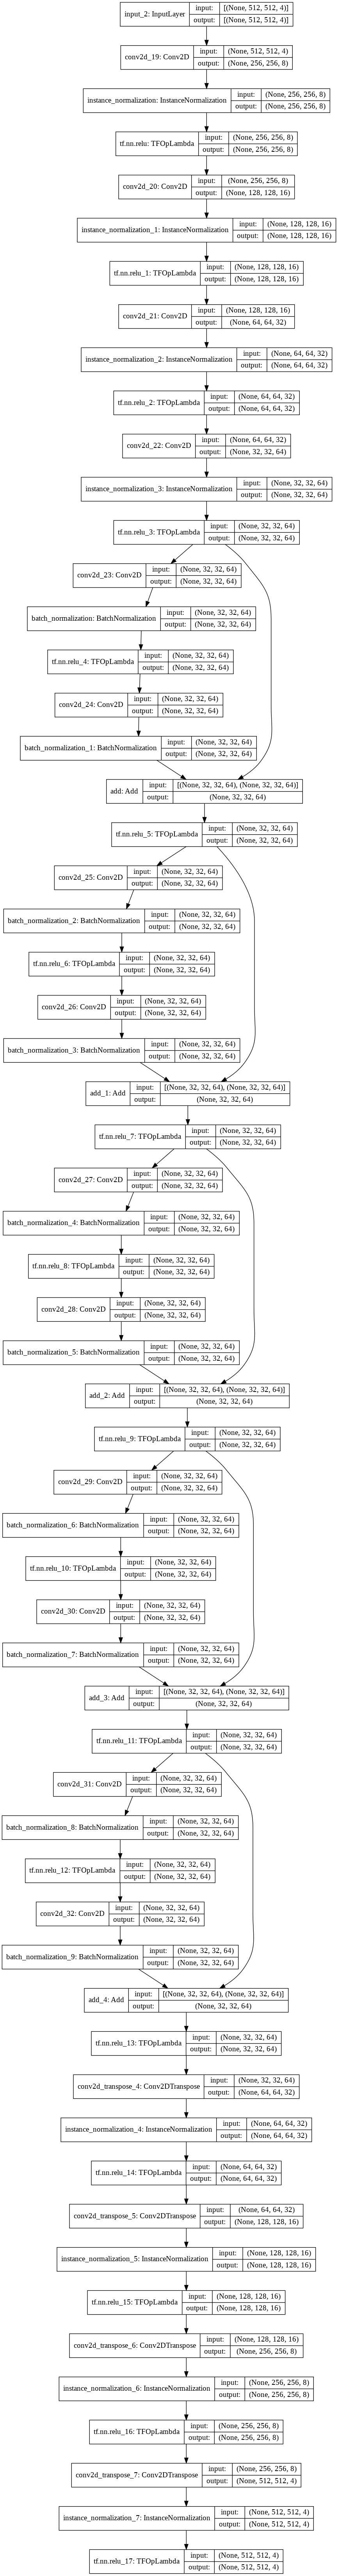

In [34]:
def ResNet(inputShape = (512,512,4), name = None,  num_up_down_blocks = 4, num_res_blocks = 5):
  inputImageChannels = inputShape[-1]

  # Define functional API
  input_tensor = tf.keras.layers.Input(shape=inputShape)
  x = input_tensor
  
  #Downsampling Blocks
  for i in range(num_up_down_blocks):
    x = DownSampleBlock(input = x, numOfChannels = inputImageChannels * (2**i))

  #Residual Blocks
  for i in range(num_res_blocks):
    x = ResidualIdentityBlock(input = x, filters = inputImageChannels * (2**num_up_down_blocks))

  #Upsampling Blocks
  for i in reversed(range(num_up_down_blocks)):
    x = UpSampleBlock(input= x, numOfChannels= inputImageChannels * (2**(i+1)))

  return tf.keras.Model(inputs=input_tensor, outputs=x, name = name)

# Test Code
model = ResNet(inputShape = (512,512,4), name = "ResNet")
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=False)

<a name="4-4-3"></a>
### 4.4.3 PatchGAN Discriminator

The PatchGAN has been used in the Pix2Pix model: https://www.tensorflow.org/tutorials/generative/pix2pix

Model: "PatchGAN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 512, 512, 4)]     0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 256, 256, 8)       288       
_________________________________________________________________
instance_normalization_8 (In (None, 256, 256, 8)       16        
_________________________________________________________________
tf.nn.relu_18 (TFOpLambda)   (None, 256, 256, 8)       0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 128, 128, 16)      1152      
_________________________________________________________________
instance_normalization_9 (In (None, 128, 128, 16)      32        
_________________________________________________________________
tf.nn.relu_19 (TFOpLambda)   (None, 128, 128, 16)      0  

<Figure size 432x288 with 0 Axes>

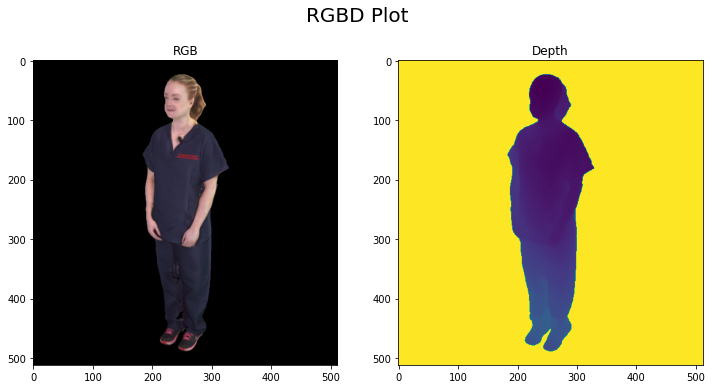

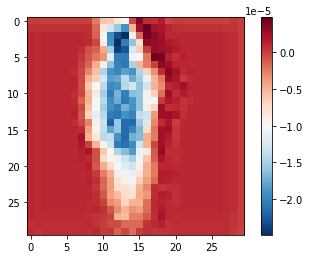

In [35]:
#%%monitor_cell “MasterThesis/PatchGAN”
def PatchGAN(inputShape = (512,512,4), name = None, num_down_blocks = 4, kernel_initializer = KERNEL_INIT):
  inputImageChannels = inputShape[-1]

  # Define functional API
  input_tensor = tf.keras.layers.Input(shape=inputShape)
  x = input_tensor

  #Downsampling Blocks
  #Downsampling Blocks
  for i in range(num_down_blocks):
    x = DownSampleBlock(input = x, numOfChannels = inputImageChannels * (2**i))

  x = tf.keras.layers.ZeroPadding2D()(x)
  x = tf.keras.layers.Conv2D(inputImageChannels * (2**(num_down_blocks + 1)), 4, strides=1, kernel_initializer = kernel_initializer, use_bias=False)(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.LeakyReLU()(x)
  x = tf.keras.layers.ZeroPadding2D()(x)
  x = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer = kernel_initializer)(x)

  return tf.keras.Model(inputs=input_tensor, outputs=x, name = name)

model = PatchGAN(inputShape = (512,512,4), name = "PatchGAN")
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=False)

# Test forward Propagation
#rgbd_samples = Combine_color_depth(DATA_PATH)
img = rgbd_synthetic[24,:,:,:]
Plot_RGBD_Sample(img)
output = model(img[tf.newaxis,...], training = False)
plt.imshow(output[0,...,-1], cmap='RdBu_r')
plt.colorbar()
#print(output)

<a name="4-4-4"></a>
### 4.4.4 CycleGAN

CycleGAN implementation of TensorFlow: https://www.tensorflow.org/tutorials/generative/cyclegan

In [36]:
class CycleGAN(tf.keras.Model):
  def __init__(self, generator_T, generator_S, discriminator_S, discriminator_T, lambda_cycle=10.0, lambda_identity=0.5):
    super(CycleGAN, self).__init__()
    
    self.modelType = "CycleGAN"
    self.gen_T = generator_T
    self.gen_S = generator_S
    self.disc_S = discriminator_S
    self.disc_T = discriminator_T
    self.lambda_cycle = lambda_cycle
    self.lambda_identity = lambda_identity

  def compile(self, gen_T_optimizer, gen_S_optimizer, disc_S_optimizer, disc_T_optimizer, gen_loss_fn, disc_loss_fn, cycle_loss_fn, identity_loss_fn):
    super(CycleGAN, self).compile()
    self.gen_T_optimizer = gen_T_optimizer
    self.gen_S_optimizer = gen_S_optimizer
    self.disc_S_optimizer = disc_S_optimizer
    self.disc_T_optimizer = disc_T_optimizer
    self.generator_loss_fn = gen_loss_fn
    self.discriminator_loss_fn = disc_loss_fn
    self.cycle_loss_fn = cycle_loss_fn
    self.identity_loss_fn = identity_loss_fn

  def call(self, input_S, input_T):
    generated_T = self.gen_T(input_S)
    generated_S = self.gen_S(input_T)
    discriminated_T = self.disc_T(input_T)
    discriminated_S = self.disc_S(input_S)
    return tf.stack([generated_T, generated_S, discriminated_T, discriminated_S])

  def build_model_from_layers(self, shape):
    x = tf.keras.layers.Input(shape=(shape))
    y = tf.keras.layers.Input(shape=(shape))
    return tf.keras.Model(inputs=[x, y], outputs=self.call(x, y))


  def print_summary(self):

    def getNumberOfElements(listOfLayers):
      numElements = 0
      for layer in listOfLayers:
        numElements += tf.reduce_prod(layer.shape)
      return numElements

    print("--------------------------------------------------")
    print("---------------- Summary Cycle GAN ---------------")
    print("--------------------------------------------------")
    
    print(" ")
    print("Generator 1:")
    gen1_total = getNumberOfElements(self.gen_T.variables)
    gen1_trainable = getNumberOfElements(self.gen_T.trainable_variables)
    gen1_nonTrainable = gen1_total - gen1_trainable
    #print("  Network Type: {}".format(self.gen_T.modelType))
    print("  Total Variables: {}".format(gen1_total))
    print("  Trainable Variables: {}".format(gen1_trainable))
    print("  Non-trainable Variables: {}".format(gen1_nonTrainable))

    print(" ")
    print("Generator 2:")
    gen2_total = getNumberOfElements(self.gen_S.variables)
    gen2_trainable = getNumberOfElements(self.gen_S.trainable_variables)
    gen2_nonTrainable = gen2_total - gen2_trainable
    #print("  Network Type: {}".format(self.gen_S.modelType))
    print("  Total Variables: {}".format(gen2_total))
    print("  Trainable Variables: {}".format(gen2_trainable))
    print("  Non-trainable Variables: {}".format(gen2_nonTrainable))

    print(" ")
    print("Discriminator 1:")
    disc1_total = getNumberOfElements(self.disc_S.variables)
    disc1_trainable = getNumberOfElements(self.disc_S.trainable_variables)
    disc1_nonTrainable = disc1_total - disc1_trainable
    #print("  Network Type: {}".format(self.disc_S.modelType))
    print("  Total Variables: {}".format(disc1_total))
    print("  Trainable Variables: {}".format(disc1_trainable))
    print("  Non-trainable Variables: {}".format(disc1_nonTrainable))

    print(" ")
    print("Discriminator 2:")
    disc2_total = getNumberOfElements(self.disc_T.variables)
    disc2_trainable = getNumberOfElements(self.disc_T.trainable_variables)
    disc2_nonTrainable = disc2_total - disc2_trainable
    #print("  Network Type: {}".format(self.disc_T.modelType))
    print("  Total Variables: {}".format(disc2_total))
    print("  Trainable Variables: {}".format(disc2_trainable))
    print("  Non-trainable Variables: {}".format(disc2_nonTrainable))

    print("_________________________________________________")

    cycleGAN_total = gen1_total + gen2_total + disc1_total + disc2_total
    cycleGAN_trainable = gen1_trainable + gen2_trainable + disc1_trainable + disc2_trainable
    cycleGAN_nonTrainable = gen1_nonTrainable + gen2_nonTrainable + disc1_nonTrainable + disc2_nonTrainable
    print("Total Variables: {}".format(cycleGAN_total))
    print("Trainable Variables: {}".format(cycleGAN_trainable))
    print("Non-trainable Variables: {}".format(cycleGAN_nonTrainable))

    print("_________________________________________________")

  def train_step(self, batch_train):
    real_S, real_T = batch_train

    # For CycleGAN, we need to calculate different
    # kinds of losses for the generators and discriminators.
    # We will perform the following steps here:
    #
    # 1. Pass real images through the generators and get the generated images
    # 2. Pass the generated images back to the generators to check if we
    #    we can predict the original image from the generated image.
    # 3. Do an identity mapping of the real images using the generators.
    # 4. Pass the generated images in 1) to the corresponding discriminators.
    # 5. Calculate the generators total loss (adverserial + cycle + identity)
    # 6. Calculate the discriminators loss
    # 7. Update the weights of the generators
    # 8. Update the weights of the discriminators
    #TODO: Check if still applicable! # 9. Return the losses in a dictionary

    with tf.GradientTape(persistent=True) as tape:
      # Horse to fake zebra
      generated_T = self.gen_T(real_S, training=True)
      # Zebra to fake horse -> y2x
      generated_S = self.gen_S(real_T, training=True)

      # Cycle (Horse to fake zebra to fake horse): x -> y -> x
      cycled_S = self.gen_S(generated_T, training=True)
      # Cycle (Zebra to fake horse to fake zebra) y -> x -> y
      cycled_T = self.gen_T(generated_S, training=True)

      # Identity mapping
      same_S = self.gen_S(real_S, training=True)
      same_T = self.gen_T(real_T, training=True)

      # Discriminator output
      disc_real_S = self.disc_S(real_S, training=True)
      disc_generated_S = self.disc_S(generated_S, training=True)

      disc_real_T = self.disc_T(real_T, training=True)
      disc_generated_T = self.disc_T(generated_T, training=True)

      # Generator adverserial loss
      gen_T_loss = self.generator_loss_fn(disc_generated_T)
      gen_S_loss = self.generator_loss_fn(disc_generated_S)

      # Generator cycle loss
      cycle_loss_T = self.cycle_loss_fn(real_T, cycled_T) * self.lambda_cycle
      cycle_loss_S = self.cycle_loss_fn(real_S, cycled_S) * self.lambda_cycle

      # Generator identity loss
      id_loss_T = self.identity_loss_fn(real_T, same_T) * self.lambda_identity
      id_loss_S = self.identity_loss_fn(real_S, same_S) * self.lambda_identity

      #print("gen_T_loss = {}, gen_S_loss = {}, cycle_loss_T = {}, cycle_loss_S = {}, id_loss_T = {}, , id_loss_S = {}".format(gen_T_loss, gen_S_loss, cycle_loss_T, cycle_loss_S, id_loss_T ,id_loss_S))

      # Total generator loss
      total_loss_T = gen_T_loss + cycle_loss_T + id_loss_T
      total_loss_S = gen_S_loss + cycle_loss_S + id_loss_S

      # Discriminator loss
      disc_S_loss = self.discriminator_loss_fn(disc_real_S, disc_generated_S)
      disc_T_loss = self.discriminator_loss_fn(disc_real_T, disc_generated_T)

    # Get the gradients for the generators
    grads_T = tape.gradient(total_loss_T, self.gen_T.trainable_variables)
    grads_S = tape.gradient(total_loss_S, self.gen_S.trainable_variables)

    # Get the gradients for the discriminators
    disc_S_grads = tape.gradient(disc_S_loss, self.disc_S.trainable_variables)
    disc_T_grads = tape.gradient(disc_T_loss, self.disc_T.trainable_variables)

    # Update the weights of the generators
    self.gen_T_optimizer.apply_gradients(
      zip(grads_T, self.gen_T.trainable_variables)
    )
    self.gen_S_optimizer.apply_gradients(
      zip(grads_S, self.gen_S.trainable_variables)
    )

    # Update the weights of the discriminators
    self.disc_S_optimizer.apply_gradients(
      zip(disc_S_grads, self.disc_S.trainable_variables)
    )
    self.disc_T_optimizer.apply_gradients(
      zip(disc_T_grads, self.disc_T.trainable_variables)
    )

    #tf.print("total_loss_T = {}, total_loss_S = {}, disc_S_loss = {}, disc_T_loss = {}".format(total_loss_T, total_loss_S, disc_S_loss, disc_T_loss))

    return [total_loss_T, total_loss_S, disc_S_loss, disc_T_loss]
    

  def test_step(self, batch_data):
    pass

  @tf.function
  def distributed_train_step(self, batch_train):
    ''' 
    per_replica_loss_vector:  vector of shape [per_replica-loss_gen1, per_replica-loss_gen2, per_replica-loss_disc1, per_replica-loss_disc1]
    reduced_loss_vector:      Vector of results of the different devices (for TPU 8)
    
    '''
    per_replica_loss_vector = strategy.run(self.train_step, args=(batch_train,))

    #reduce the result of the replicas for every loss value returned!
    reduced_loss_vector = []
    for per_replica_loss in per_replica_loss_vector:
      reduced_loss_vector.append(strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None))
    
    return reduced_loss_vector

  @tf.function
  def distributed_test_step(self, data):
    #TODO: strategy.run(test_step, args=(data,))
    pass

<a name="4-2"></a>
## 4.2 Custom Callbacks

<a name="5"></a>
# 5. Training the Model

TODO:
- Define Checkpoint
- Define metrics
- Track the loss

<a name="5-x"></a>
## 5.x Training Specific Parameters

In [37]:
# Number of epochs to train the model
EPOCHS = 5
INPUT_SHAPE = (512, 512, 4)

<a name="5-x"></a>
## 5.x Model Preparation

In [38]:
with strategy.scope():
  #generator_T = ResNet(INPUT_SHAPE, name = "Generator_T")
  #generator_S = ResNet(INPUT_SHAPE, name = "Generator_S")
  #generator_T = UNet(INPUT_SHAPE, num_up_down_blocks = 6, name = "Generator_T")
  #generator_S = UNet(INPUT_SHAPE, num_up_down_blocks = 6, name = "Generator_S")
  generator_T = UNet(INPUT_SHAPE, name = "Generator_T")
  generator_S = UNet(INPUT_SHAPE, name = "Generator_S")
  discriminator_T = PatchGAN(INPUT_SHAPE, name = "Discriminator_T")
  discriminator_S = PatchGAN(INPUT_SHAPE, name = "Discriminator_S")

  cycleGAN = CycleGAN(generator_T, generator_S, discriminator_T, discriminator_S )
  cycleGAN.print_summary()

--------------------------------------------------
---------------- Summary Cycle GAN ---------------
--------------------------------------------------
 
Generator 1:
  Total Variables: 34514116
  Trainable Variables: 34514116
  Non-trainable Variables: 0
 
Generator 2:
  Total Variables: 34514116
  Trainable Variables: 34514116
  Non-trainable Variables: 0
 
Discriminator 1:
  Total Variables: 158353
  Trainable Variables: 158097
  Non-trainable Variables: 256
 
Discriminator 2:
  Total Variables: 158353
  Trainable Variables: 158097
  Non-trainable Variables: 256
_________________________________________________
Total Variables: 69344938
Trainable Variables: 69344426
Non-trainable Variables: 512
_________________________________________________


In [39]:
cycleGAN.compile(
  gen_T_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
  gen_S_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
  disc_T_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
  disc_S_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
  gen_loss_fn = generator_loss_fn,
  disc_loss_fn = discriminator_loss_fn,
  cycle_loss_fn = cycle_loss_fn,
  identity_loss_fn = identity_loss_fn
)



Checkpoint: https://www.tensorflow.org/guide/checkpoint

In [40]:
#checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=cycleGAN)

NameError: ignored

Metrics: https://www.tensorflow.org/api_docs/python/tf/keras/metrics

In [41]:
train_metric = tf.keras.metrics.MeanSquaredError()

<a name="5-x"></a>
## 5.x Training Loop



In [42]:
#%%monitor_cell “MasterThesis/TrainingLoop”

with strategy.scope():
  
  train_distributed, test_distributed = get_Datasets(rgbd_synthetic, rgbd_target)
  
  #setup progressbar
  #train_size = int(train_synthetic.__len__())

  #pbar1 = tqdm(total=EPOCHS, position=0, leave=True, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} ')
  for epoch in range(EPOCHS):
    start_time = time.time()
    #pbar = tqdm(total=train_size, position=0, leave=True, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} ')  

    # TODO: Initialize Losses. Loss vector containg the loss of each Model [total_loss_gen1, total_loss_gen2, total_loss_disc1, total_loss_disc2]
    total_loss = [0., 0., 0., 0.]
    num_batches = 0

    #for batch in tf.data.Dataset.zip((train_synthetic_distributed, train_target_distributed)):
    for batch_train in train_distributed:
      total_loss = tf.math.add(total_loss, cycleGAN.distributed_train_step(batch_train))
      num_batches += 1

    # average over all batches in the current epoch
    total_loss = total_loss / float(num_batches)
  
      #pbar.set_description("Training Loop... Epoch: {} of {}, batch: {}".format((epoch+1), EPOCHS, num_batches)) #works better if set in every loop! 
      #pbar.update()

    epoch_time = round(time.time() - start_time, 6)
    print("Training: Epoch: {} of {}. Duration: {} seconds, Loss Gen1 = {}, Loss Gen2 = {}, Loss Disc1 = {}, Loss Disc2 = {}".format((epoch +1), EPOCHS,epoch_time, total_loss[0], total_loss[1], total_loss[2], total_loss[3]))
    
    #if epoch % 50 == 0:
      #print("Saving Checkpoint...")
      #checkpoint.save(checkpoint_prefix)  
    #pbar1.set_description("Training: Epoch: {} of {}. Loss Gen1 = {}, Loss Gen2 = {}, Loss Disc1 = {}, Loss Disc2 = {}".format((epoch +1), EPOCHS, total_loss[0], total_loss[1], total_loss[2], total_loss[3])) #works better if set in every loop! 
    #pbar1.update()

    #TODO: Implement test loop
    #for batch in tf.data.Dataset.zip((test_synthetic, test_target)):
    #  distributed_test_step(batch)

    #TODO: Print Epoch info and progress etc...

    #TODO: Reset metrics, and test loss

Get Datasets ...

Dataset created. Total samples: 30, training split: 0.8, training samples: 24, test samples: 6

Dataset created. Total samples: 30, training split: 0.8, training samples: 24, test samples: 6
Training: Epoch: 1 of 5. Duration: 88.100304 seconds, Loss Gen1 = 0.9973309636116028, Loss Gen2 = 0.9970226287841797, Loss Disc1 = 0.49851179122924805, Loss Disc2 = 0.4986640512943268
Training: Epoch: 2 of 5. Duration: 4.606384 seconds, Loss Gen1 = 0.9864323139190674, Loss Gen2 = 0.9848901629447937, Loss Disc1 = 0.49247443675994873, Loss Disc2 = 0.49323058128356934
Training: Epoch: 3 of 5. Duration: 4.565215 seconds, Loss Gen1 = 0.9678766131401062, Loss Gen2 = 0.9645267128944397, Loss Disc1 = 0.4824279844760895, Loss Disc2 = 0.4840470552444458
Training: Epoch: 4 of 5. Duration: 5.019747 seconds, Loss Gen1 = 0.9360749125480652, Loss Gen2 = 0.9300150871276855, Loss Disc1 = 0.46566709876060486, Loss Disc2 = 0.46846720576286316
Training: Epoch: 5 of 5. Duration: 4.601135 seconds, Loss

GPU & AUTO REDUCTION: 

Loss Gen1 = 0.19329231977462769, Loss Gen2 = 0.20428431034088135, Loss Disc1 = 0.0008987663895823061, Loss Disc2 = 9.010988287627697e-05

GPU & SUM REDUCTION: 

Loss Gen1 = 38892.765625, Loss Gen2 = 37622.48046875, Loss Disc1 = 0.029141411185264587, Loss Disc2 = 1.0732263326644897

TPU & SUM REDUCTION: 

ERROR

<a name="6"></a>
# 6. Validating the Model

<a name="A"></a>
# A. TESTING AND DEBUGGING

In [43]:
#Prepare_filename(directory):
#rgbd_samples = Combine_color_depth(DATA_PATH)
#Plot_RGBD_Sample(rgbd_samples[24,:,:,:])
#Plot_Multiple_RGBD(rgbd_samples)
#Create_tensorflow_dataset(rgbd_samples)